In [1]:
import numpy as np
from driving.env import *
from matplotlib import pyplot as plt
import random
from ipywidgets import interactive
from IPython.display import clear_output

In [10]:
oval = make_oval()
env = DrivingEnv(dt=0.5)
DEG_FACTOR = 1/180
actions = (-35.0, -10.0, 0.0, 10.0, 35.0)
discount = 0.9

def policy(s):
    d, a = oval.distance_angle_deg(s[0], s[1], s[2])
    if random.random() < 0.7:
       return random.choice(actions)
    return -100*d - 2*a + 20.0*np.random.normal()
    # return 0.0
    
def good_policy(s):
    d, a = oval.distance_angle_deg(s[0], s[1], s[2])
    return -100*d - 2*a

In [3]:
def sim(policy, n_steps=1000):
    env = DrivingEnv()
    s = env.reset()
    history = []
    for i in range(n_steps):
        a = policy(s)
        sp, r, done, info = env.step(a)
        history.append((s, a, r, sp))
        s = sp
    return history

def showmodel(model, theta=0.0, a=0.0):
    plt.gca().clear()
    N = 20
    theta = theta*DEG_FACTOR
    a = a*DEG_FACTOR
    x = np.linspace(-1.0, 4.0, N)
    y = np.linspace(-1.0, 3.0, N)
    X, Y = np.meshgrid(x, y)
    Z = np.empty(X.shape)
    sa = np.empty((Z.size, 4))
    for i in range(Z.shape[0]):
        for j in range(Z.shape[1]):
            x = X[i,j]
            y = Y[i,j]
            sa[i*Z.shape[1]+j, :] = np.array((x, y, theta, a))

    qs = np.clip(model.predict(sa), -100.0, 0.0)
    for i in range(Z.shape[0]):
        for j in range(Z.shape[1]):
            Z[i,j] = qs[i*Z.shape[1]+j].item()

    plt.contourf(X,Y,Z)
    plt.colorbar()
    return plt.gca()

In [14]:
history = sim(good_policy)

reward sum: -0.9572207525726097


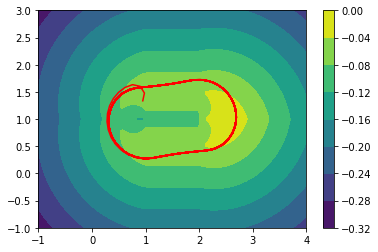

In [15]:
N = 100
x = np.linspace(-1.0, 4.0, N)
y = np.linspace(-1.0, 3.0, N)
X, Y = np.meshgrid(x, y)
Z = np.empty(X.shape)
for i in range(Z.shape[0]):
    for j in range(Z.shape[1]):
        x = X[i,j]
        y = Y[i,j]
        # d, a = oval.distance_angle(x, y, 0.0)
        r = env.reward(np.array((x,y,90.0)), 0.0)
        Z[i,j] = r
plt.contourf(X,Y,Z)
xs = [step[0][0] for step in history]
ys = [step[0][1] for step in history]
drsum = sum([discount**i*history[i][2] for i in range(len(history))])
print(f'reward sum: {drsum}')
plt.plot(xs, ys, color='red')
plt.colorbar()

In [6]:
from keras.models import Sequential
from keras.layers import Dense

model = Sequential()
model.add(Dense(units=64, activation='relu', input_dim=4))
model.add(Dense(units=64, activation='relu'))
# model.add(Dense(1, kernel_initializer='normal'))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
newmodel = True

Using TensorFlow backend.
W0813 00:38:49.848339 140532110739264 deprecation_wrapper.py:119] From /home/zach/anaconda3/envs/ai4all/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0813 00:38:49.861009 140532110739264 deprecation_wrapper.py:119] From /home/zach/anaconda3/envs/ai4all/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0813 00:38:49.862652 140532110739264 deprecation_wrapper.py:119] From /home/zach/anaconda3/envs/ai4all/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0813 00:38:49.896337 140532110739264 deprecation_wrapper.py:119] From /home/zach/anaconda3/envs/ai4all/lib/python3.7/site-packages/keras/optimizers.py:790: The name tf.train.Optimizer is depr

iteration 99


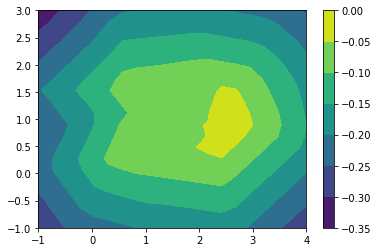

9.118577003479004
-0.3083850145339966
[-0.04303329437971115, -0.016889214515686035, -0.007345575839281082, -0.01625007763504982, -0.041432514786720276]
Epoch 1/30
10000/10000 [==============================] - 1s 80us/step - loss: 1.2845e-04
Epoch 2/30
10000/10000 [==============================] - 1s 90us/step - loss: 1.2505e-04
Epoch 3/30
10000/10000 [==============================] - 1s 83us/step - loss: 1.1073e-04
Epoch 4/30
10000/10000 [==============================] - 1s 82us/step - loss: 1.0657e-04
Epoch 5/30
10000/10000 [==============================] - 1s 85us/step - loss: 1.1472e-04
Epoch 6/30
10000/10000 [==============================] - 1s 80us/step - loss: 1.1895e-04
Epoch 7/30
10000/10000 [==============================] - 1s 75us/step - loss: 1.1499e-04
Epoch 8/30
10000/10000 [==============================] - 1s 75us/step - loss: 1.3304e-04
Epoch 9/30
10000/10000 [==============================] - 1s 81us/step - loss: 1.1510e-04
Epoch 10/30
10000/10000 [=============

In [9]:
N = 100

for k in range(100):
    clear_output()
    print(f'iteration {k}')
    ax = showmodel(model, theta=90.0)
    plt.show()
    sa_buffer = np.zeros(shape=(0,4))
    r_buffer = []
    sp_buffer = []
    for i in range(N):
        history = sim(policy, n_steps=100)
        for step in history:
            sa = np.concatenate((step[0], (step[1],)))
            sa_buffer = np.vstack((sa_buffer, sa*(1.0, 1.0, DEG_FACTOR, DEG_FACTOR)))
            r_buffer.append(step[2])
            sp_buffer.append(step[3])
    
    qspa = np.zeros(shape=(N*100,len(actions)))
    for i in range(len(actions)):
        a = np.full((N*100,1), actions[i]*DEG_FACTOR)
        spa = np.concatenate((np.array(sp_buffer), a), axis=1)
        qspa[:,i] = np.ndarray.flatten(model.predict(spa))
    maxq = np.amax(qspa, 1)
    print(np.amax(maxq))
    print(np.amin(maxq))
    maxq = np.clip(maxq, -20.0/(1.0-discount), 0.0)
    
    s = (2.5, 1.0, 90.0*DEG_FACTOR)
    print([model.predict(np.reshape(np.array([*s, a*DEG_FACTOR]), (1,4))).item() for a in actions])
      
    if newmodel:   
        target = np.array(r_buffer)
        newmodel = False
    else:
        target = np.array(r_buffer) + discount*maxq

    model.fit(sa_buffer, target, epochs=30, batch_size=32, shuffle=True)

In [108]:
model.predict(np.array([[1.0, 0.5, 0.0, -15.0*deg_factor]]))

array([[-1.0731428]], dtype=float32)

In [21]:
interactive(lambda theta, a: showmodel(model, theta, a), theta=(0,360), a=(-30.0, 30.0))

interactive(children=(IntSlider(value=180, description='theta', max=360), FloatSlider(value=0.0, description='…

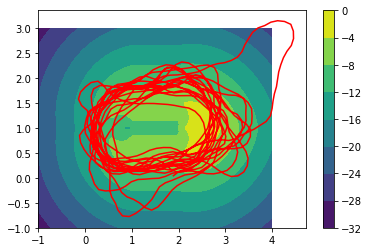

In [10]:
N = 100
x = np.linspace(-1.0, 4.0, N)
y = np.linspace(-1.0, 3.0, N)
X, Y = np.meshgrid(x, y)
Z = np.empty(X.shape)
for i in range(Z.shape[0]):
    for j in range(Z.shape[1]):
        x = X[i,j]
        y = Y[i,j]
        # d, a = oval.distance_angle(x, y, 0.0)
        r = env.reward(np.array((x,y,90.0)), 0.0)
        Z[i,j] = r
plt.contourf(X,Y,Z)
xs = [step[0][0] for step in history]
ys = [step[0][1] for step in history]
plt.plot(xs, ys, color='red')
plt.colorbar()

In [29]:
def nn_policy(s):
    maxq = -float("inf")
    maxa = 0.0
    for a in actions:
        arr_s = np.array(s)
        arr_a = np.array((a,))
        sa = np.concatenate((arr_s, arr_a))
        q = model.predict(np.reshape(sa*(1.0, 1.0, DEG_FACTOR, DEG_FACTOR), (1,4))).item()
        if q > maxq:
            maxq = q
            maxa = a
    return maxa

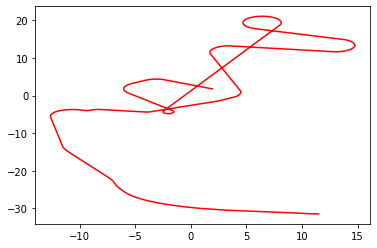

In [31]:
history = sim(nn_policy)
xs = [step[0][0] for step in history]
ys = [step[0][1] for step in history]
plt.plot(xs, ys, color='red')